In [3]:
## config
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json
import multiprocessing
import matplotlib.pyplot as plt
import torch.nn.functional as F
# from data_utils import get_dataloaders
import argparse
import einops
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

In [4]:

def set_seed(seed):
    """Set the seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# Define the Deep MLP model
# class DeepMLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(DeepMLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         return x

# Function to calculate Mean Absolute Error (MAE)
def calculate_mae(outputs, labels):
    mae = torch.mean(torch.abs(outputs - labels)).item()
    return mae


In [5]:
class DeepMLP(nn.Module):
    def __init__(self, p, hidden_size=24):
        super(DeepMLP, self).__init__()
        self.p = p  # modulo value (e.g., 67)
        self.hidden_size = hidden_size
        
        # First layer with shared weights for both inputs
        self.W_input = nn.Linear(p, hidden_size, bias=True)
        self.relu1 = nn.ReLU()
        
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        
        # Output layer
        self.W_output = nn.Linear(hidden_size, 1, bias=True)

    def forward(self, x):
        # Extract a and b from input
        a = x[:, 0].long()  # first number from each pair
        b = x[:, 1].long()  # second number from each pair
        
        # One-hot encode both numbers
        a_onehot = F.one_hot(a, num_classes=self.p).float()
        b_onehot = F.one_hot(b, num_classes=self.p).float()
        
        # First layer with shared weights
        hidden = self.relu1(self.W_input(a_onehot) + self.W_input(b_onehot))
        
        # Second hidden layer
        hidden = self.fc2(hidden)
        hidden = self.relu2(hidden)
        
        # Output layer
        output = self.W_output(hidden)
        
        return output

In [6]:
class MLP(nn.Module):
    def __init__(self, p, hidden_size=24):
        super(MLP, self).__init__()
        self.p = p  # modulo value (e.g., 67)
        self.hidden_size = hidden_size  # 24 neurons as specified
        
        # Single weight matrix for both inputs
        self.W_input = nn.Linear(p, hidden_size, bias=True)
        
        # Output layer
        self.W_output = nn.Linear(hidden_size, 1, bias=True)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Extract a and b from input
        a = x[:, 0].long()  # first number from each pair
        b = x[:, 1].long()  # second number from each pair
        
        # One-hot encode both numbers (convert to vectors of length p)
        a_onehot = F.one_hot(a, num_classes=self.p).float()
        b_onehot = F.one_hot(b, num_classes=self.p).float()
        
        # ReLU(a_one_hot * W_input + b_one_hot * W_input)
        hidden = self.relu(self.W_input(a_onehot) + self.W_input(b_onehot))
        
        # W_output layer
        output = self.W_output(hidden)
        
        return output

In [7]:
def train_mlp_orig(input_data, labels, val_data, val_labels, hidden_size=24, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(p=67, hidden_size=hidden_size).to(device)
    elif depth == "deep":
        model = DeepMLP(p=67, hidden_size=hidden_size).to(device)  
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    # Move data to device
    input_tensor = input_data.to(device)
    labels_tensor = labels.to(device)
    val_tensor = val_data.to(device)
    val_labels_tensor = val_labels.to(device)   

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_mae = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_mae)

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_mae = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_mae)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

In [8]:
gpu_device = 3
device = torch.device(f"cuda:{gpu_device}")

In [9]:
p = 67
frac_train = 0.2

# Optimizer config
# lr = 1e-3
# wd = 1. 
# betas = (0.9, 0.98)

# num_epochs = 25000
# checkpoint_every = 100

DATA_SEED = 598

In [10]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
# equals_vector = einops.repeat(torch.tensor(67), " -> (i j)", i=p, j=p)

In [11]:
# dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).to(device)
dataset = torch.stack([a_vector, b_vector], dim=1).to(device)
print(dataset[:5])
print(dataset.shape)

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]], device='cuda:3')
torch.Size([4489, 2])


In [12]:
labels = (dataset[:, 0] + dataset[:, 1]) % p
print(labels.shape)
print(labels[:5])

torch.Size([4489])
tensor([0, 1, 2, 3, 4], device='cuda:3')


In [13]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p*p)
cutoff = int(p*p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data[:5])
print(train_labels[:5])
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[39, 63],
        [53, 57],
        [36, 62],
        [27, 52],
        [18, 59]], device='cuda:3')
tensor([35, 43, 31, 12, 10], device='cuda:3')
torch.Size([897, 2])
tensor([[43, 25],
        [ 5,  0],
        [45, 53],
        [ 9,  4],
        [25, 66]], device='cuda:3')
tensor([ 1,  5, 31, 13, 24], device='cuda:3')
torch.Size([3592, 2])


Using device: cuda:3
Epoch [100/1000], Loss: 1074.0917, Validation Loss: 1084.5919, Train MAE: 27.2721, Val MAE: 27.3372
Epoch [200/1000], Loss: 359.4606, Validation Loss: 378.8583, Train MAE: 16.3573, Val MAE: 16.8652
Epoch [300/1000], Loss: 349.2344, Validation Loss: 389.0890, Train MAE: 16.1103, Val MAE: 17.0442
Epoch [400/1000], Loss: 345.8701, Validation Loss: 399.3655, Train MAE: 15.9985, Val MAE: 17.2176
Epoch [500/1000], Loss: 345.0695, Validation Loss: 404.8067, Train MAE: 15.9542, Val MAE: 17.3057
Epoch [600/1000], Loss: 344.6897, Validation Loss: 406.3124, Train MAE: 15.9329, Val MAE: 17.3296
Epoch [700/1000], Loss: 332.0213, Validation Loss: 397.7054, Train MAE: 15.5397, Val MAE: 17.0430
Epoch [800/1000], Loss: 296.5101, Validation Loss: 371.5853, Train MAE: 14.3743, Val MAE: 16.1457
Epoch [900/1000], Loss: 244.9919, Validation Loss: 328.4007, Train MAE: 12.4139, Val MAE: 14.4969
Epoch [1000/1000], Loss: 185.4771, Validation Loss: 273.0467, Train MAE: 9.7451, Val MAE: 12.01

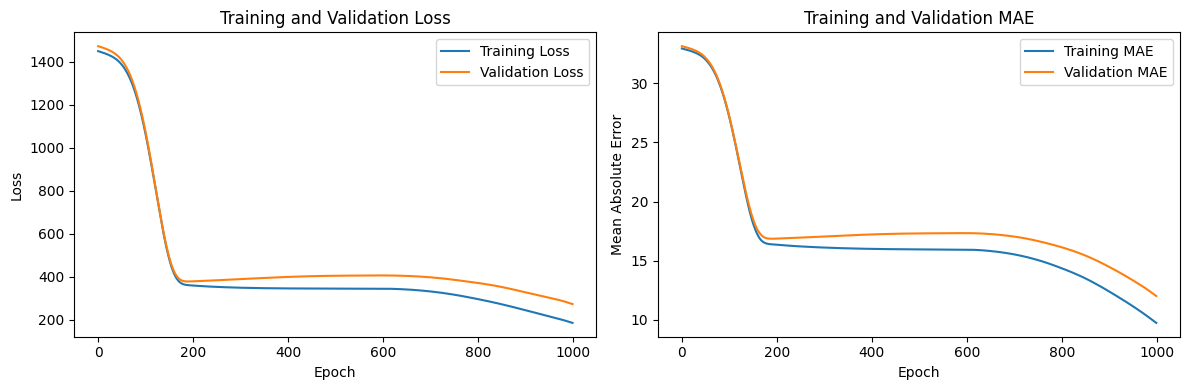

In [17]:
# reshaping the labels to match what the model expects
# The model expects labels as a 2D tensor with shape (n_samples, 1)
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

# Convert data to float type if not already
train_data = train_data.float()
test_data = test_data.float()
train_labels = train_labels.float()
test_labels = test_labels.float()

# Train the model
results = train_mlp_orig(
    input_data=train_data,
    labels=train_labels,
    val_data=test_data,
    val_labels=test_labels,
    hidden_size=32,          
    learning_rate=0.001,     
    epochs=1000,             
    seed=42,
    gpu_device=3,           # Set to None if you want to use CPU
    l2_lambda=0.1,         # weight decay
    depth="deep",        # or "deep" if you want to use the deeper model
    print_step=100          # Print progress every 100 epochs
)

# After training, you can access:
trained_model = results["model"]
training_losses = results["training_losses"]
validation_losses = results["validation_losses"]
training_accuracies = results["training_acc"]
validation_accuracies = results["validation_acc"]

# Optional: Plot the training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training MAE')
plt.plot(validation_accuracies, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()

# To make predictions with the trained model:
def predict(model, input_data):
    model.eval()
    with torch.no_grad():
        predictions = model(input_data.float())
    return predictions

# Example prediction on test data
test_predictions = predict(trained_model, test_data)